In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


In [2]:
const STATIC_LECTURE = false;

In [3]:
function draw(plt)
    if STATIC_LECTURE
        filename = Base.Filesystem.tempname() * ".png"
        savefig(filename)
        return display("image/png", read(filename))
    else
        return plt
    end
end

draw (generic function with 1 method)

In [4]:
using Plots; default(label=nothing, l=2, size=(800,500));
if !STATIC_LECTURE
    using Interact;
end

WebIO._IJuliaInit()

### Warmups

1. What is the induced 2-norm of unitary matrix?

2. Can you prove this fact from last lecture?

If $D\in\mathbb{C}^{m \times m}$ is diagonal,

$$
\|D\|_p = \max_{1 \leq i \leq m} |d_i|, \quad 1\leq p \leq \infty.
$$

Start with the definition of the matrix $p$-norm:

$$
\|D\|_p = \sup_{\|x\|_p = 1} \| D x \|_p = \dots
$$

In [5]:
using LinearAlgebra

m = 5
d = randn(m)

5-element Vector{Float64}:
 -0.2093701556995464
  1.446854370345132
 -0.959211236951573
 -0.3566322766785229
 -1.0906010621275406

In [6]:
D = diagm(d)
opnorm(D,1) # in Julia `opnorm` is the induced norm

1.446854370345132

In [7]:
opnorm(D,2)

1.446854370345132

In [8]:
opnorm(D,Inf)

1.446854370345132

# Norms (Part II) and the SVD

1. **Cauchy-Schwarz / Hölder Inequalities and Duality**
2. **Submultiplicativity**
3. **Frobenius Norm and Invariance under Unitary Multiplication**
4. **SVD: Geometric Observation**
5. **Reduced SVD, Full SVD, and Formal Definition**

## Review: Induced Matrix Norm

Given norms $\|\cdot\|_{(m)}$ and $\|\cdot\|_{(n)}$ on $\mathbb{C}^m$ and $\mathbb{C}^n$,

$$
\| A \|_{(m,n)} = \sup_{\|x\|_{(n)} = 1} \| A x \|_{(m)} = \sup_{x \neq 0} \frac{\| A x \|_{(m)}}{\| x \|_{(n)}}.
$$

If $(m) = (n) = p$, we say $\| \cdot \|_p$.

Two cases where $\| A \|_{p}$ can be computed directly:

1.
$$
\| A \|_1 = \max_{1\leq j \leq n} \| a_j \|_1, \quad a_j\text{ column of }A.
$$

2.
$$
\| A \|_\infty = \| A^* \|_1 = \max_{1 \leq i \leq m} \| a_i^* \|_1 \quad a_i^*\text{ row of }A.
$$

In [9]:
m = 3; n = 2
A = randn(m,n)

3×2 Matrix{Float64}:
  0.19566   -0.825315
 -0.774215   0.336398
  0.445447   0.16743

In [10]:
norm.([A[:,1],A[:,2]],1)

2-element Vector{Float64}:
 1.4153220735194338
 1.3291424706520814

In [11]:
opnorm(A,1)

1.4153220735194338

For general $1 < p < \infty$ (most importantly $p=2$) and general $A$, $\|A\|_p$ _cannot be computed exactly in finite steps!_

We still use $\|A\|_p$ (particularly $p\in\{1,2,\infty\}$) all the time because it can be approximated very quickly.

## Cauchy-Schwarz and Hölder Inequalities

If $\frac{1}{p} + \frac{1}{q} = 1$, $1 \leq p, q \leq \infty$, the **Hölder inequality** states that

$$
| x^* y | \leq \| x \|_p \| y \|_q, \quad \forall x, y \in\mathbb{C}^m.
$$

In [12]:
m = 4; p = 1. + rand(); q = 1 / (1 - 1 /p);
[p q]

1×2 Matrix{Float64}:
 1.28079  4.56143

In [13]:
x = randn(m); y = randn(m);
[x y]

4×2 Matrix{Float64}:
  1.1651     0.257495
 -0.901254   1.10413
  0.207017   0.779227
 -1.26996   -1.42635

In [14]:
abs(x'*y)

1.2776218261413368

In [15]:
[norm(x,p) norm(y,q) norm(x,p)*norm(y,q)]

1×3 Matrix{Float64}:
 2.70835  1.52944  4.14227

### Proof, case $p=1$, $q=\infty$

$$
\big|\sum_{i=1}^m u_i v_i \big| \leq \sum_{i=1}^m |u_i v_i| \leq \max_{1\leq i \leq m} |v_i| \sum_{i=1}^m |u_i| = \|u\|_1 \|v\|_\infty$$

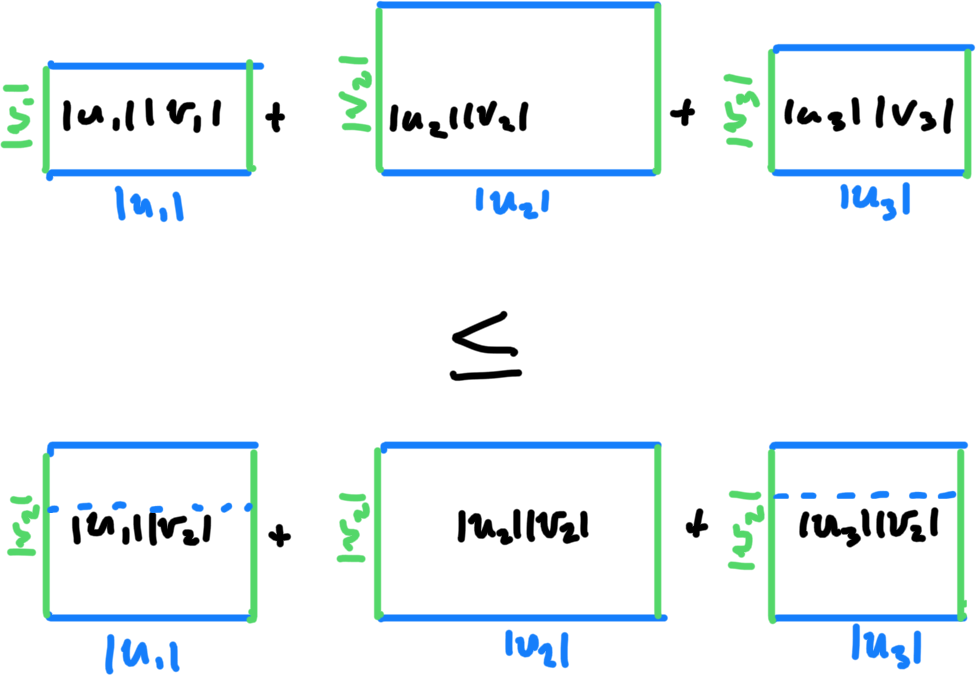

## Proof, case $p = q = 2$ (Cauchy-Schwarz)

Recall $\cos \alpha_{xy} = \frac{x^*y}{\|x\|_2\|y\|_2}$:

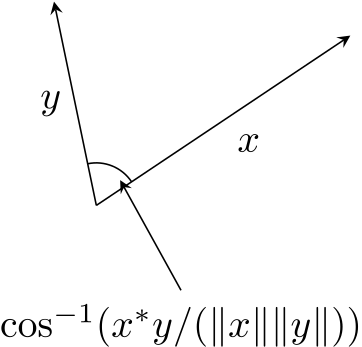

$$
|x^*y| = |\cos \alpha_{xy}| \|x\|_2 \|y\|_2 \leq \|x\|_2 \|y\|_2.
$$

### Proof, general case

$$|x^* y| \leq \|x\|_p \|y\|_q, \quad \frac{1}{p} + \frac{1}{q} = 1, \quad x,y\in\mathbb{C}^{m}.$$

Challenge exercise (Hölder's inequality = [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality) + [Young's Inequality](https://en.wikipedia.org/wiki/Young%27s_inequality_for_products))

### T&B, Example 3.6: The 2-norm of an Outer Product

**Claim:** Given $A = uv^*$, $u\in\mathbb{C}^m$, $v \in \mathbb{C}^n$, $\|A\|_2 = \|u\|_2 \|v\|_2$.

_Proof._ First show $\|A\|_2 \leq \|u\|_2 \|v\|_2$.

Expand the definition ...
$$
\|A\|_2 = \sup_{\|x\|_2 = 1} \|Ax\|_2 = \sup_{\|x\|_2 = 1} \|u v^* x\|_2
$$

Using homogeneous scaling of norms ...
$$=\sup_{\|x\|_2 = 1} |v^*x| \|u\|_2 = \|u\|_2 \sup_{\|x\|_2 = 1} |v^* x|$$

... and apply Cauchy-Schwarz
$$
\leq \|u\|_2 \sup_{\|x\|_2 =1} \|v\|_2 \|x\|_2 =\|u\|_2 \|v\|_2.
$$

To prove equality:

$$\|A v\|_2 = \|u v^*v\|_2 = \|v\|_2^2 \|u\|_2 \Rightarrow \frac{\|Av\|_2}{\|v\|_2} = \|v\|_2 \|u\|_2.$$ 

### Dual norms

If $\frac{1}{p} + \frac{1}{q} = 1$,

$$\|x\|_p = \frac{\|x\|_p \|y\|_q}{\|y\|_q} \geq \frac{|x^* y|}{\|y\|_q} \Rightarrow \|x\|_p \geq \sup_{y \neq 0} \frac{|x^*y|}{\|y\|_q}.$$

This is in fact an equality. $\|\cdot \|_p$ and $\|\cdot \|_q$ are _dual norms:_

$$\|x\|_p = \sup_{\|y\|_q = 1} |x^*y|, \quad \|y\|_q = \sup_{\|x\|_p = 1} |y^*x|.$$
(Compare HW1, problem 7)

### Consequence: $\|A\|_p = \|A^*\|_q$
$$\|A\|_p = \sup_{\|x\|_p = 1} \|Ax\|_p = \sup_{\|x\|_p = 1, \|y\|_q = 1} |(Ax)^* y|$$

$$ = \sup_{\|y\|_q = 1, \|x\|_p = 1} |x^*(A^* y)| = \sup_{\|y\|_q = 1} \| A^* y\|_q = \|A^*\|_q.$$

## Induced matrix norms are _submultiplicative_

For any induced norm and $x\neq 0$,

$$\big\| A \frac{x}{\|x\|}\big\| \leq \sup_{y\neq 0} \big\| A \frac{y}{\|y\|}\big\| =
\sup_{y \neq 0} \frac{\|Ay\|}{\|y\|} = \|A\|.$$

$$\Rightarrow \|Ax\| \leq \|A\|\|x\|, \quad \forall x.$$

Now consider the induced norm of the product matrix $AB$:

$$\|(AB)x\| = \|A(Bx)\| \leq \|A\|\|Bx\| \leq \|A\|\|B\|\|x\|, \quad \forall x.$$

$$\Rightarrow \frac{\|(AB)x\|}{\|x\|} \leq \|A\|\|B\|, \quad \forall x.$$

$$\Rightarrow \|AB\| = \sup_{x\neq 0} \frac{\|(AB)x\|}{\|x\|} \leq \|A\|\|B\|.$$

We say induced matrix norms are _submultiplicative_.

In [16]:
m = 10; k = 8; n = 5; p = 1

A = randn(10,8); B = randn(8,5);

[opnorm(A*B,2) opnorm(A,2)*opnorm(B,2)]

1×2 Matrix{Float64}:
 10.6901  16.256

## Frobenius norm

Remember, $\mathbb{C}^{m \times n}$ is a _vector space:_ not all norms have to be induced norms.

A very important norm that is not an induced norm is the **Frobenius norm** $\|\cdot \|_F$:

$$
\|A\|_F = \left(\sum_{i=1}^m\sum_{j=1}^n |a_{ij}|^2\right)^{1/2}.
$$

(Think of it as the 2-norm of $A$ unrolled as a vector.)

In [17]:
A = rand(4,3)

4×3 Matrix{Float64}:
 0.547046  0.454915  0.561929
 0.616621  0.258109  0.235697
 0.146872  0.369287  0.698522
 0.795774  0.194501  0.972814

In [18]:
norm(A,2) # Frobenius norm (treat A as a vector)

1.8941222485681726

In [19]:
norm(reshape(A,(12,)),2)

1.8941222485681726

In [20]:
opnorm(A,2) # Induced 2-norm

1.806238158376859

### Frobenius norm is the Frobenius norm of the adjoint

$$
\|A\|_F = \left(\sum_{i=1}^m\sum_{j=1}^n |a_{ij}|^2\right)^{1/2}
=
\left(\sum_{j=1}^n\sum_{i=1}^m |\bar a_{ij}|^2\right)^{1/2}
=
\|A^*\|_F
$$

In [21]:
[norm(A, 2) norm(A', 2)]

1×2 Matrix{Float64}:
 1.89412  1.89412

### Frobenius norm = 2-norm of column 2-norms = 2-norm of row 2-norms

$$
\|A\|_F = \left(\sum_{j=1}^n \|a_j\|_2^2\right)^{1/2} = \left(\sum_{i=1}^m \|a_i^*\|_2^2\right)^{1/2}.
$$

In [22]:
[norm(A,2) norm([norm.(A[:,j],2) for j = 1:3]) norm([norm.(A[i,:]) for i = 1:4])]

1×3 Matrix{Float64}:
 1.89412  1.89412  1.89412

### Frobenius norm is related to trace

Recall that the _trace_ of a square matrix (sum of the diagonal) is also the sum of the eigenvalues of the matrix (repeated with algebraic multiplicity):

$$
\mathrm{tr}(A) = \sum_{i=1}^m a_{ii} = \sum_{\lambda \in \rho(A)} \lambda_i \cdot \underbrace{\mu_i}_{\text{multiplicity of }\lambda_i}
$$

The Frobenius norm is

$$
\|A\|_F = \sqrt{\mathrm{tr}(A^* A)} = \sqrt{\mathrm{tr}(AA^*)}.
$$

In [23]:
[norm(A,2) sqrt(tr(A' * A)) sqrt(tr(A * A'))]

1×3 Matrix{Float64}:
 1.89412  1.89412  1.89412

(This fact is very useful for proving things about $\|\cdot\|_F$ without
expanding the summation.)

### The Frobenius norm is also submultiplicative

Let $A\in \mathbb{C}^{m \times k}, B \in \mathbb{C}^{k \times n}$, and let $a_i^*$ be the $i$th row of $A$ and let $b_j$ be the $j$th column of $B$:

$$
\|AB\|_F^2 = \sum_{i=1}^m \sum_{j=1}^n |a_i^* b_j|^2
$$

(apply Cauchy-Schwarz)

$$\leq \sum_{i=1}^m \sum_{j=1}^n \|a_i^*\|_2^2 \| b_j \|_2^2 = \left(\sum_{i=1}^m \|a_i^*\|_2^2\right)
\left(\sum_{j=1}^n \|b_j\|_2^2\right) = \|A\|_F^2 \|B\|_F^2$$

### Exercise: Unitary Invariance of Matrix 2-norm and Frobenius Norm

**T&B Theorem 3.1:** For any $A\in \mathbb{C}^{m \times n}$ and unitary $Q \in \mathbb{Q}^{m \times m}$, we have

$$\|QA\|_2 = \|A\|_2, \quad \|QA\|_F = \|A\|_F.$$

Hints:

1. What is the relationship of a unitary matrix to the _vector_ 2-norm?
2. Use the trace definition of the Frobenius norm.

_Proof._


## The Singular Value Decomposition: Geometric Observation

When $A \in \mathbb{R}^{2 \times 2}$ is diagonal, the unit circle maps to an _oriented_ ellipse (extrema on the coordinate axis).
But even for general $A$, the unit circle seems to map to a tilted ellipse.

In [24]:
function plotAx(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,1],[0,0],arrow=1,text=["",("e₁", :left)])
    plot!(dplot, [0,0],[0,1],arrow=1,text=["",("e₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(rplot, [0,a1[1]],[0,a1[2]],arrow=1,text=["",("a₁", :left)])
    plot!(rplot, [0,a2[1]],[0,a2[2]],arrow=1,text=["",("a₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

In [25]:
if STATIC_LECTURE
    plot1=plotAx(2.,0.0,0.,0.5)
    plot2=plotAx(1.,0.5,0.2,0.5)
    draw(plot(plot1,plot2,layout=(2,1)))
else
    a11=widget(-2.0:0.1:2.0, value=-2.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.0, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.0, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.5, label="a₂₂")
    iplot = map(plotAx,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a₁₁"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/tisaac/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2935b9880, Task (runnable) @0x00007fd2935b9880), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-0

> The image of the unit sphere under any $m \times n$ matrix is a hyperellpse.

### Plotting preimages of the extrema revealing

The extrema (_principlel semiaxes_) of the tilted ellipse are orthogonal (true of any ellipse), but the _preimages_ of the extrema are also orthogonal.

In [26]:
function plotAx_svd(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,1],[0,0],arrow=1,text=["",("e₁", :left)])
    plot!(dplot, [0,0],[0,1],arrow=1,text=["",("e₂", :bottom)])
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("A⁻¹x₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("A⁻¹x₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,a1[1]],[0,a1[2]],arrow=1,text=["",("a₁", :left)])
    plot!(rplot, [0,a2[1]],[0,a2[2]],arrow=1,text=["",("a₂", :bottom)])
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("x₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("x₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

In [27]:
if STATIC_LECTURE
    plot2=plotAx_svd(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a₁₁"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
31, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/tisaac/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd22b142b30, Task (runnable) @0x00007fd22b142b30), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-

### Relabel $A^{-1} x_i = v_i$, $x_i = A v_i$

In [28]:
function plotAx_svd2(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("v₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("v₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("Av₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("Av₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

In [29]:
if STATIC_LECTURE
    plot2=plotAx_svd2(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd2,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a₁₁"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
31, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/tisaac/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd22b13f6b0, Task (runnable) @0x00007fd22b13f6b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-

- Declare the ratio $\frac{\|Av_i\|_2}{\|v_i\|_2}$ to be the _singular value_ $\sigma_i$.
- Declare the normalized vector $\frac{1}{\|A v_i\|_2} A v_i$ to be $u_i$.

### $A: v_i \mapsto \sigma_i u_i$

In [30]:
function plotAx_svd3(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("v₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("v₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("σ₁u₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("σ₂u₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

In [31]:
if STATIC_LECTURE
    plot2=plotAx_svd3(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd3,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

(div { style=Dict("display" => "flex", "flex-direction" => "column") }
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["a₁₁"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
31, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/tisaac/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2277d2120, Task (runnable) @0x00007fd2277d2120), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-2.0\",\"-1.9\",\"-1.8\",\"-1.7\",\"-1.6\",\"-1.5\",\"-1.4\",\"-1.3\",\"-1.2\",\"-1.1\",\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-

_This defines $A$, and we can do this for any $A$._

This is the geometric description of the _singular value decomposition_ of $A$

## SVD: Formal definition

### Reduced SVD

Assume $A \in \mathbb{C}^{m \times n}$. The orthonormal _left singular vectors_ $\{u_j\}$ are related to the orthonormal _right singular vectors_ $\{v_j\}$ by

$$
Av_j = \sigma u_j, \quad 1 \leq j \leq n.
$$

Write this out in matrix form:

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
v_1 & v_2 & \dots & v_n \\
& & & \\
& & & \\
\end{array}
\right]
=
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
& & & \\
u_1 & u_2 & \dots & u_n \\
& & & \\
& & & \\
& & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\end{bmatrix}.
$$

$$
A V = \hat{U}\hat{\Sigma}, \quad V \in \mathbb{C}^{n \times n}, \hat{U} \in \mathbb{C}^{m \times n}, \hat{\Sigma} \in \mathbb{R}^{n \times n} \text{(diagonal, nonnegative)}.
$$

$V$ has $n$ orthonormal columns in $\mathbb{C}^{n}$: it is unitary.  We can muliply both sides on the right by $V^* = V^{-1}$:

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
=
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
& & & \\
u_1 & u_2 & \dots & u_n \\
& & & \\
& & & \\
& & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\end{bmatrix}
\begin{bmatrix}
& & v_1^* & & \\ \hline
& & v_2^* & & \\ \hline
& & \vdots & & \\ \hline
& & v_n^* & & \\
\end{bmatrix}.
$$


$$
A = \hat{U}\hat{\Sigma}V^*, \quad V \in \mathbb{C}^{n \times n}, \hat{U} \in \mathbb{C}^{m \times n}, \hat{\Sigma} \in \mathbb{R}^{n \times n} \text{(diagonal, nonnegative)}.
$$

If $m > n$, this is the **reduced SVD**.

Note that though columns of $\hat{U}$ are orthogonal, $\hat{U}$ is not unitary if $m > n$ (because it is not square).

### Full SVD

If we complement $\hat{U}$ with additional orthonormal vectors to create an orthonormal basis of $\mathbb{C}^{m}$,

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
=
\left[
\begin{array}{ccc|c|c|c}
& & & & & \\
& & & & & \\
& & & & & \\
& \hat{U}&  & u_{n+1} & \dots & u_m \\
& & & & & \\
& & & & & \\
& & & & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\ \hline
& & & \\
& & & \\
& & &
\end{bmatrix}
\begin{bmatrix}
& & v_1^* & & \\ \hline
& & v_2^* & & \\ \hline
& & \vdots & & \\ \hline
& & v_n^* & & \\
\end{bmatrix},
$$
we get the _full SVD_ of $A$,

$$
A = U \Sigma V^*, \quad U \in \mathbb{C}^{m \times m}\text{ (unitary) },\quad V\in\mathbb{C}^{n \times n}\text{ (unitary) },\quad \Sigma \in \mathbb{R}^{m \times n}\text{ (positive, diagonal) }.
$$

### The extra vectors

The vectors $\{u_{n+1},\dots, u_m\}$ that complete $U$ can be _any_ orthonormal basis of
the orthogonal complement of $\hat{U}$.

### Example

1. First compute a reduced SVD (and confirm that $A = \hat{U} \hat{\Sigma} V^*$ up to rounding error).

In [32]:
m = 5; n = 3
A = randn(5,3)
U_hat, sigma_hat, V = svd(A, full=false)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
5×3 Matrix{Float64}:
 -0.11277   -0.621287   0.115808
  0.136525   0.224767  -0.552755
 -0.180352  -0.594413   0.169253
 -0.757641   0.42014    0.400134
 -0.601745  -0.183406  -0.701639
singular values:
3-element Vector{Float64}:
 3.7572654257347313
 1.2219359812320139
 0.7141292786792061
Vt factor:
3×3 Matrix{Float64}:
  0.00288937  -0.984759   -0.173902
 -0.313677     0.164233   -0.935219
 -0.949525    -0.0572512   0.308422

In [33]:
Sigma_hat = diagm(sigma_hat)
U_hat * Sigma_hat * V' - A

5×3 Matrix{Float64}:
  0.0          -4.44089e-16   7.77156e-16
  5.55112e-17   4.44089e-16  -4.996e-16
  0.0          -5.55112e-16   7.77156e-16
 -1.66533e-16   1.33227e-15   1.66533e-16
  1.11022e-16   8.88178e-16   4.996e-16

2. Compute a full SVD (and show that the first 3 columns of $U$ are $\hat{U}$).

In [34]:
U, sigma, V = svd(A, full=true)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
5×5 Matrix{Float64}:
 -0.11277   -0.621287   0.115808   0.330463  -0.691859
  0.136525   0.224767  -0.552755   0.788482   0.0599975
 -0.180352  -0.594413   0.169253   0.264696   0.717939
 -0.757641   0.42014    0.400134   0.295406  -0.0457165
 -0.601745  -0.183406  -0.701639  -0.334309  -0.0143465
singular values:
3-element Vector{Float64}:
 3.7572654257347313
 1.2219359812320139
 0.7141292786792061
Vt factor:
3×3 Matrix{Float64}:
  0.00288937  -0.984759   -0.173902
 -0.313677     0.164233   -0.935219
 -0.949525    -0.0572512   0.308422

In [35]:
U[:,1:3] - U_hat[:,1:3]

5×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [36]:
sigma - sigma_hat

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [37]:
Sigma = [diagm(sigma);zeros(2,3)] 
U * Sigma * V' - A

5×3 Matrix{Float64}:
  0.0          -3.88578e-16   6.66134e-16
  5.55112e-17   4.44089e-16  -4.996e-16
  4.16334e-17  -5.55112e-16   6.66134e-16
 -1.66533e-16   1.33227e-15   1.52656e-16
  1.11022e-16   8.88178e-16   4.996e-16

3. Rotate the extra vectors to make $U_{\text{new}}$ and show that the SVD is unaffected.

In [38]:
U_extra = U[:,4:end]

θ = rand()
R = [[cos(θ);sin(θ)] [-sin(θ);cos(θ)]]
U_extra_new = U_extra * R
U_new = [U_hat U_extra_new]
U - U_new

5×5 Matrix{Float64}:
 0.0  0.0  0.0   0.52421     0.0499878
 0.0  0.0  0.0   0.147259    0.522747
 0.0  0.0  0.0  -0.400667    0.34006
 0.0  0.0  0.0   0.0991587   0.179764
 0.0  0.0  0.0  -0.0695913  -0.219024

In [39]:
U_new * Sigma * V' - A

5×3 Matrix{Float64}:
  0.0          -3.88578e-16   6.66134e-16
  5.55112e-17   4.44089e-16  -4.996e-16
  4.16334e-17  -5.55112e-16   6.66134e-16
 -1.66533e-16   1.33227e-15   1.52656e-16
  1.11022e-16   8.88178e-16   4.996e-16

### Formal definition

A _singular value decomposition_ (SVD) of $A \in \mathbb{C}^{m \times n}$ (do not require $m \geq n$) is a factorization

$$
A = U \Sigma V^*,\quad U \in \mathbb{C}^{m \times m}\text{ (unitary) },\quad V\in\mathbb{C}^{n \times n}\text{ (unitary) },\quad \Sigma \in \mathbb{R}^{m \times n}\text{ (positive, diagonal) },
$$

where we further require $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_p \geq 0$ ($p = \min\{m,n\}$).

### Existence and Uniqueness

**Theorem:** (Slightly modified from T&B Theorem 4.4)

Every matrix $A$ has a singular value decomposition.  If $U \Sigma V^*$ and $\tilde{U} \tilde{\Sigma} \tilde{V}^*$ are
two SVDs of $A$, then $\Sigma = \tilde{\Sigma}.$ If $i \neq j$, then either

1. $u_i^* \tilde u_j = 0$, or

2. $\sigma_i = \sigma_j$ (taking $\sigma_i = 0$ if $i > \min\{m,n\}$).

The same is true of the vectors in $V$ and $\tilde V$.

### T&B Exercise 4.4

Two matrices $A, B \in \mathbb{C}^{m \times m}$ are _unitarily equivalent_ if $A = Q B Q^*$ for some unitary
$Q \in \mathbb{C}^{m \times m}$.  Is it true or false that $A$ and $B$ are unitarily equivalent if and only if they have the same singular values?